# Chapter 10: LASSO Regression

In [1]:
%reset
low_memory=False
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 10.1 Introduction & Motivation

We have seen many powerful machine learning methods for regression and classification. However, in the presence of high-dimensional datasets, these models can become prone to overfitting and difficult to interpret. This is where **LASSO Regression** comes in.

LASSO (Least Absolute Shrinkage and Selection Operator) is a type of analysis typically used in regression models that performs both variable selection and regularization. It introduces a penalty term to the linear regression cost function to shrink some coefficients to exactly zero, effectively removing them from the model. This helps in creating simpler, more interpretable models while improving generalization.

## 10.2 Problem Setting

Imagine we have a dataset with hundreds of features, but only a handful of them are truly relevant for predicting the target variable. Up till now we would plainly throw all features at the model, even ones we could classify as 'noise', potentially leading to a model that is overly complex and performs poorly on unseen data.

When we train a normal linear regression model we would get a formula that looks something like this:

$$y = \beta_0 + \beta_1 x  + \beta_2 x + \beta_3 x + \beta_4 x + \beta_5 x + ...$$

Without a penalty, all features contribute, even if some barely matter. Lasso adds a cost or **penalty** for having large coefficients, so if a certain feature doesn't help much in the final model, Lasso shrinks its coefficient or beta. It uses optimization to find the best coefficients that minimize both the prediction error and the penalty. It doesn’t just subtract a fixed value from the coefficients — rather, it tries to shrink the coefficients in a way that reduces the total cost. If a feature doesn’t improve predictions enough to justify its penalty, its coefficient gets lowerd to 0 which in turn means the feature gets dropped from the dataset.

The result is simpler model where some coefficients were lowered, and others where set to 0, effectively dropping the corresponding feature from the equation.

## 10.3 Model

### 10.3.1 Model 

We will explore this by looking at lasso in its simplest form: linear regression. We will dive back into the advertising dataset we used all the way back during our first 'real' class of data science fundamentals. This dataset should not be new, but just to refresh your memory we will quickly recap it. The dataset contains information regarding  sales (in thousands of units) for a particular product as well as advertising budgets (in thousands of dollars) for TV, radio, and newspaper media were issued that month.

In [2]:
df = pd.read_csv("Advertising.csv")
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


The column 'sales' contains the value we want to predict, and is thus our 'y' column. Knowing this, we can prepare a training and testing dataset.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('sales', axis=1), df['sales'], test_size=0.2, random_state=42)

### 10.3.1 Model

Before we have a look at lasso regression, we need to take a small step back. We want to see exactly how a lassoo regresion model is an improvement over a linear regression model, but for that we first need to have a trained linear regression model.

In [4]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))

Linear Regression R2 Score: 0.8994380241009121
Linear Regression MSE: 3.1740973539761015


Now, let’s use lasso regression and compare the results. You will notice we are introducing a new parameter called `alpha`. This parameter controls the penalty:

- **Higher alpha:** More regularization (shrinks more coefficients to zero).
- **Lower alpha:** Less regularization (similar to linear regression).

For now, we will start with an alpha of 1. Further down this notebook we will explore how to pick a better value.

In [5]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

y_pred_ls = lasso.predict(X_test)

print("LASSO Regression R2 Score:", r2_score(y_test, y_pred_ls))
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_ls))

LASSO Regression R2 Score: 0.9004013443377963
LASSO Regression MSE: 3.1436915053679364


### 10.3.2 Model Improvement

We can see that our R2 and MSE values did indeed change. In this case, they improved slightly! Of course right now this is just dumb luck, as we randomly set our penalty to 1. It is possible that this value is way to high, way to low or close but not quite yet at its optimal spot.

There are a few ways we can improve this. The first is a quick manual check. Here we just plot the R2 and MSE for a lot of values of alpha and visually compare them.

##### Question 1: Go over all values of alpha between 0 and 10 with an increment of 0.1. Plot the resulting R2 and MSE.

In [6]:
r2s = []
mses = []

steps = np.arange(0.1, 10.1, 0.1)

for x in steps:
    lasso = Lasso(alpha=x)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    r2s.append(r2_score(y_test, y_pred))
    mses.append(mean_squared_error(y_test, y_pred))

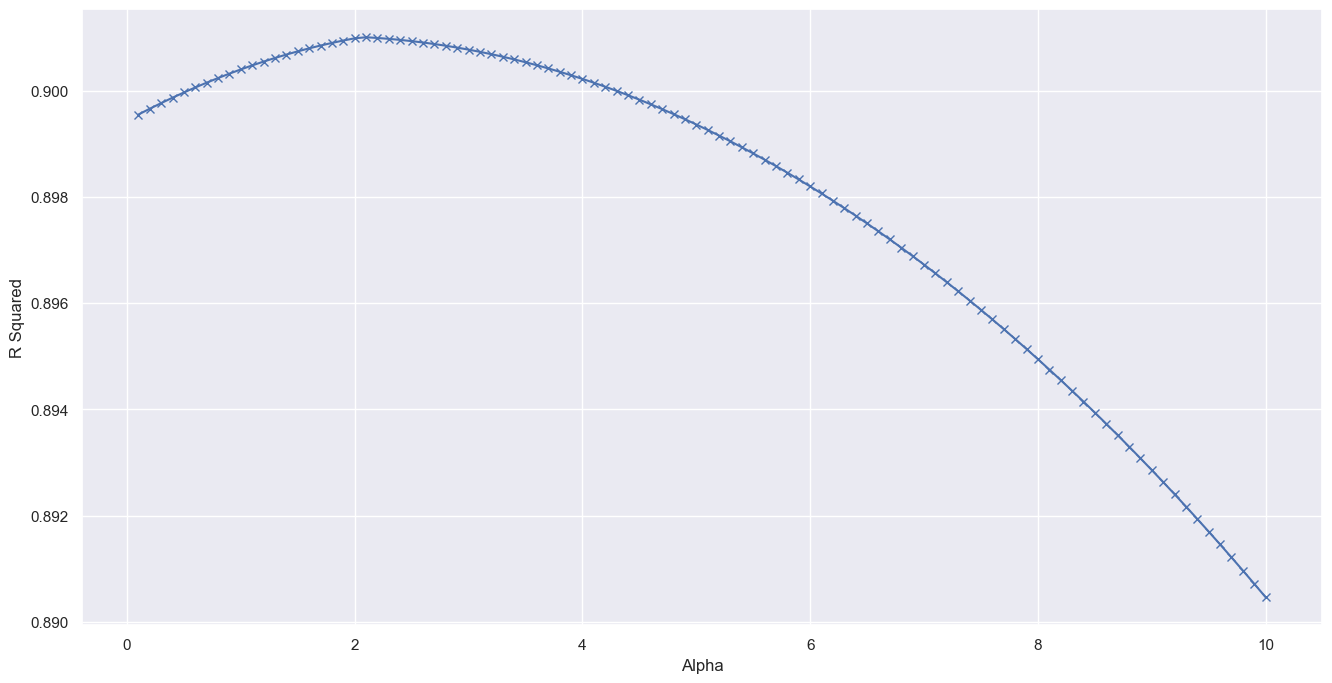

In [7]:
plt.figure(figsize=(16,8))
plt.plot(steps, r2s, 'bx-')
plt.ylabel('R Squared')
plt.xlabel('Alpha')
plt.show()

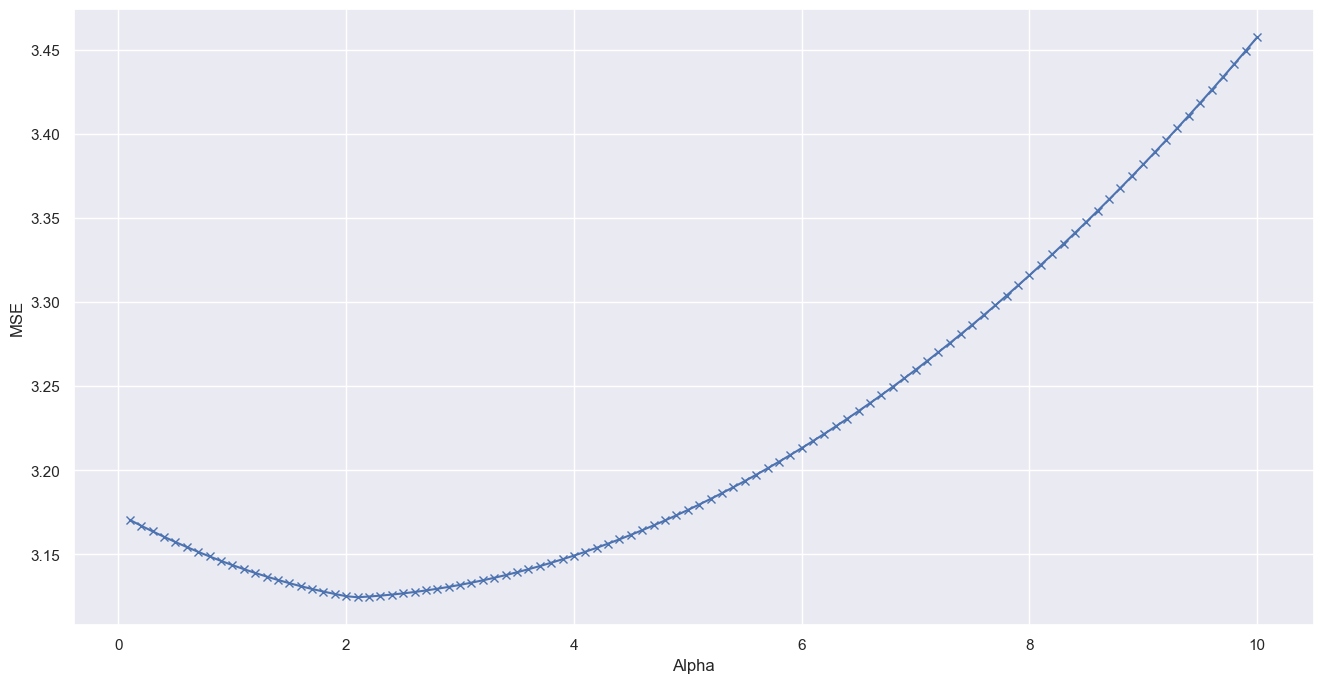

In [8]:
plt.figure(figsize=(16,8))
plt.plot(steps, mses, 'bx-')
plt.ylabel('MSE')
plt.xlabel('Alpha')
plt.show()

We can see our max R2 is reach at an alpha value just over two. The same can be said for our minimal MSE!

##### Question 2: Do you notice anything peculiar about both plots (or both graphs if you drew them on the same plot)? Can you explain why this is?

We can see that both plots are roughly the same plot, just inverted. This is to be expected, as when our model is less complex and generally better, we have a high R2 and a low MSE. When our model is worse, we have a low R2 and a high MSE.

It's nice to have a visual overview of the best value for alpha, but it would be even better if we could just run some code and get the best value automatically. Well, it seems like santa came a bit early this year as we actually have some magic code like this!

By making use of **Grid Search Cross Validation**, a variant of Cross Validation, we can get a simple and clean answer. First, we need to pass on a 'grid' or a list of alphas, then we also need to define our amount of folds as well as our scoring method. . For each possible value of alpha, it will perform cross validation using the amount of folds provided. The result is a single 'best' alpha based on all attempts by the model which we can use in our lasso regression.

In [11]:
alpha_grid = {'alpha': np.logspace(-3, 1, 50)}
lasso_cv = GridSearchCV(Lasso(), param_grid=alpha_grid, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)

print("Best Alpha from CV:", lasso_cv.best_params_['alpha'])

Best Alpha from CV: 1.2648552168552958


##### Question 3: Compare the best value for alpha you retrieved here with the one you found visually in question one. Is this the same? Is it different? explain.

In our plot we visually identified the best value for alpha to be somewhere just above two. Using our grid search cross validation however, we received an alpha of 1.26. While this value is different, they are not far from each other.

It's also not surprising to see different values. grid search cross validation is, as the name implies, a variant of cross validation. We have seen this exact type of behaviour in cross validation before. In fact, it is exactly why we use cross validation! To root out possible bias is subsets of the data and introduce randomness, giving us a more balanced and representative result.

## 10.4 Exercises

##### Question 1: See section 10.3.2
##### Question 2: See section 10.3.2
##### Question 3: See section 10.3.2
##### Question 4: Create a new lasso regression model using the new best alpha. Compare R2 and MSE.

In [9]:
lasso = Lasso(alpha=2.2)
lasso.fit(X_train, y_train)

y_pred_ls = lasso.predict(X_test)

print("LASSO Regression R2 Score:", r2_score(y_test, y_pred_ls))
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_ls))

LASSO Regression R2 Score: 0.9009933436477511
LASSO Regression MSE: 3.125005879648243


In [10]:
lasso = Lasso(alpha=3.24)
lasso.fit(X_train, y_train)

y_pred_ls = lasso.predict(X_test)

print("LASSO Regression R2 Score:", r2_score(y_test, y_pred_ls))
print("LASSO Regression MSE:", mean_squared_error(y_test, y_pred_ls))

LASSO Regression R2 Score: 0.9006694301738415
LASSO Regression MSE: 3.135229752948876


Both values for alpha (the one found visually and the one found using cross validation) produce a higher R2 and lower MSE than the original lasso regression model with an alpha of 1, as expected.

##### Question 5: As said in the beginning, lasso regression isn't just a regularization technique but can also be used for feature selecting. Explain how lasso regression could be used to drop certain columns from the original dataset.

Lasso regression works by minimizing each coefficient using a penalty. When a feature is no longer positively contributing to the model, its coefficient gets reduced to zero and the feature is eliminated. looking at the final model we can see which features are used and which are dropped. Using this information, we can drop the 'useless' features in our original dataset.